COSC2793 Computational Machine Learning: Semester 1 2024 - Assignment 1 (30%)

Read in Libraries & Set Notebook Width

In [1]:
# Data cleaning and manipulation
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Read in raw data from directory

In [2]:
# read in training and test data
df_raw_train_w_target = pd.read_csv('./dataset/train.csv', index_col='ID')
df_raw_test = pd.read_csv('./dataset/test.csv', index_col='ID')

# create a copy of the training data, without the target variable and another with just the target variable
df_raw_train = df_raw_train_w_target.drop(columns='TARGET_LifeExpectancy')
df_raw_train_target_only = df_raw_train_w_target['TARGET_LifeExpectancy']

# Print shape of the training and test data
print(f'Training data shape: {df_raw_train.shape}')
print(f'Test data shape: {df_raw_test.shape}')

Training data shape: (2071, 22)
Test data shape: (867, 22)


EDA Insights Summary:
- Feature distributions are predominantly right-skewed, except for Diphtheria, Polio, and Schooling which are left-skewed.
- Data types vary: Status is binary, Year is ordinal, and Country is nominal.
- Data clustering is evident, indicating both polynomial and linear relationships between features and the target.
- Outliers are present in both training and test sets, with potential for cleaning in the training dataset.
- Training and test sets show similar statistical properties, including mean, standard deviation, and interquartile range.
- Significant scale differences exist between features (e.g., Alcohol vs. GDP), highlighting the need for feature scaling.
- Several features exhibit strong positive correlations, often due to being related attributes (e.g., overall adult mortality and gender-specific mortality rates).
- Many features show neutral correlation with the target and other variables, suggesting limited impact on prediction outcomes.

In [4]:
# check if there is any overlap in country between train and test
train_countries = df_raw_train['Country'].unique()
test_countries = df_raw_test['Country'].unique()
overlap = [country for country in train_countries if country in test_countries]
print('Countries which are in both train and test sets:', overlap)

Countries which are in both train and test sets: []


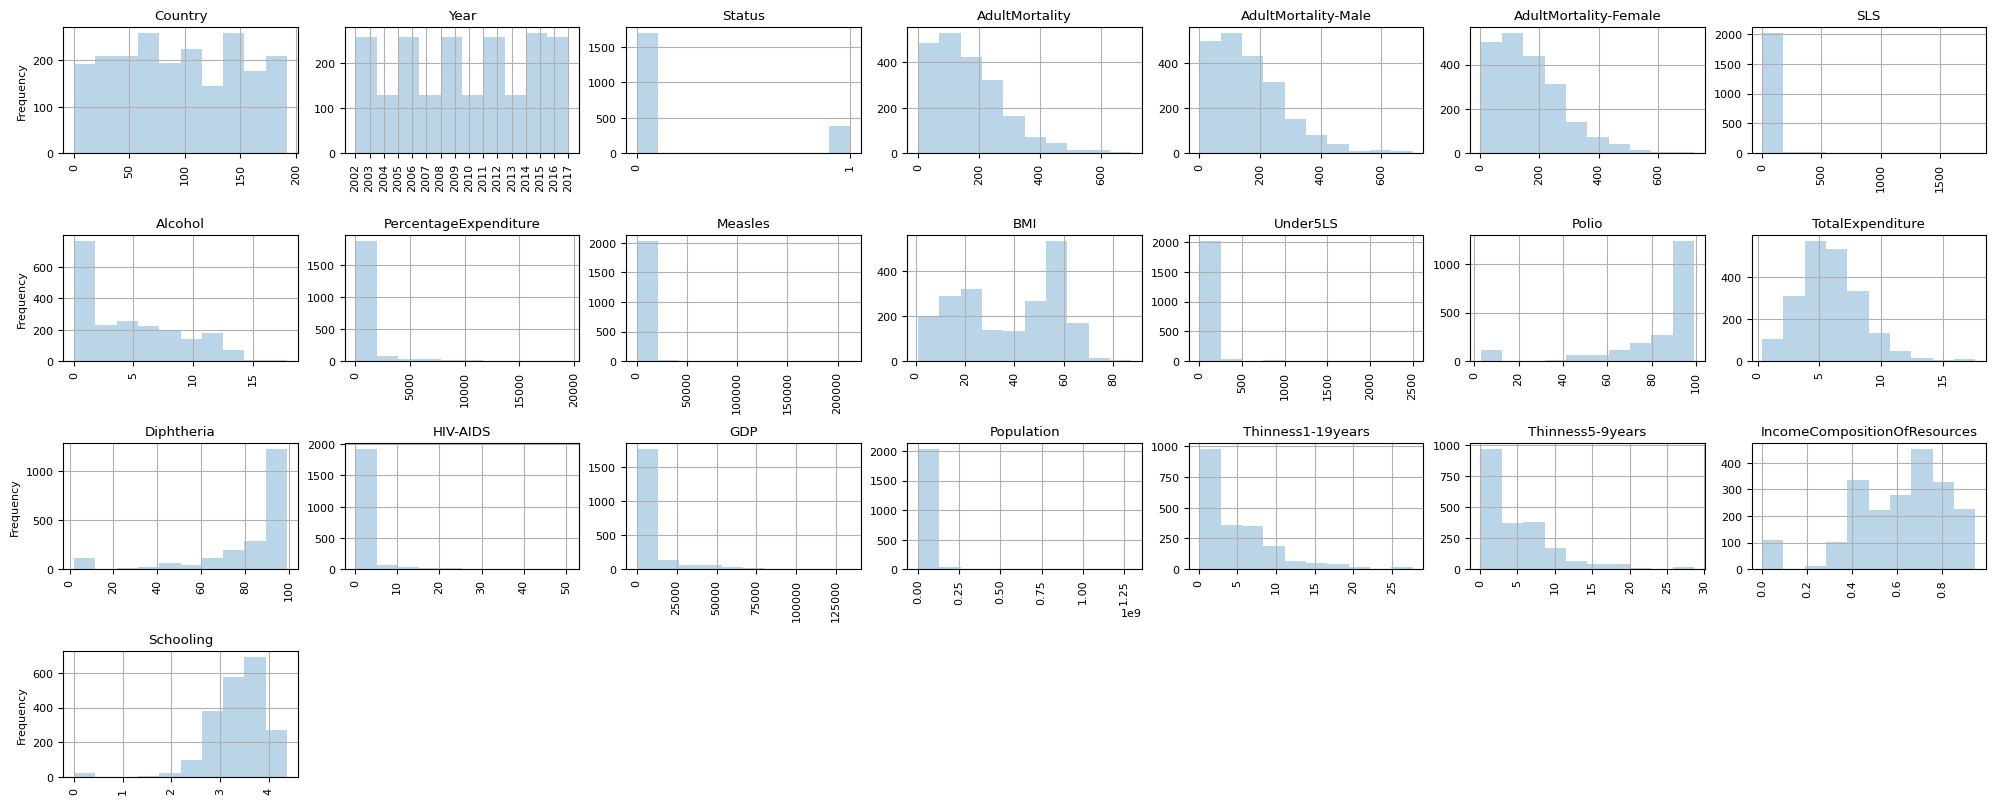

In [5]:
# Build a histogram of independent variables
plt.rcParams.update({'font.size': 8})  # Adjust font size here

# Calculate the number of columns and the required grid size
num_columns = len(df_raw_train.columns)
cols_in_grid = 7  # Number of columns in each row of the grid
rows_in_grid = 5  # Ceiling division to ensure enough rows

plt.figure(figsize=(20, 10))
# Loop through each input feature in the DataFrame and plot a histogram
for i, col in enumerate(df_raw_train.columns):
    plt.subplot(rows_in_grid, cols_in_grid, i+1)
    plt.hist(df_raw_train[col], alpha=0.3, density=False)
    plt.title(col)
    plt.xticks(rotation='vertical')
    # label the x-axis if there are fewer than 20 unique values
    if len(df_raw_train[col].unique()) < 20:
        plt.xticks(df_raw_train[col].unique())
    # label the y axis (only the first column in the grid as all are counts)
    if i % cols_in_grid == 0:
        plt.ylabel('Frequency')
    plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

/Users/jenniferpayne/opt/anaconda3/envs/jen/lib/python3.11/site-packages/seaborn/regression.py:254: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)


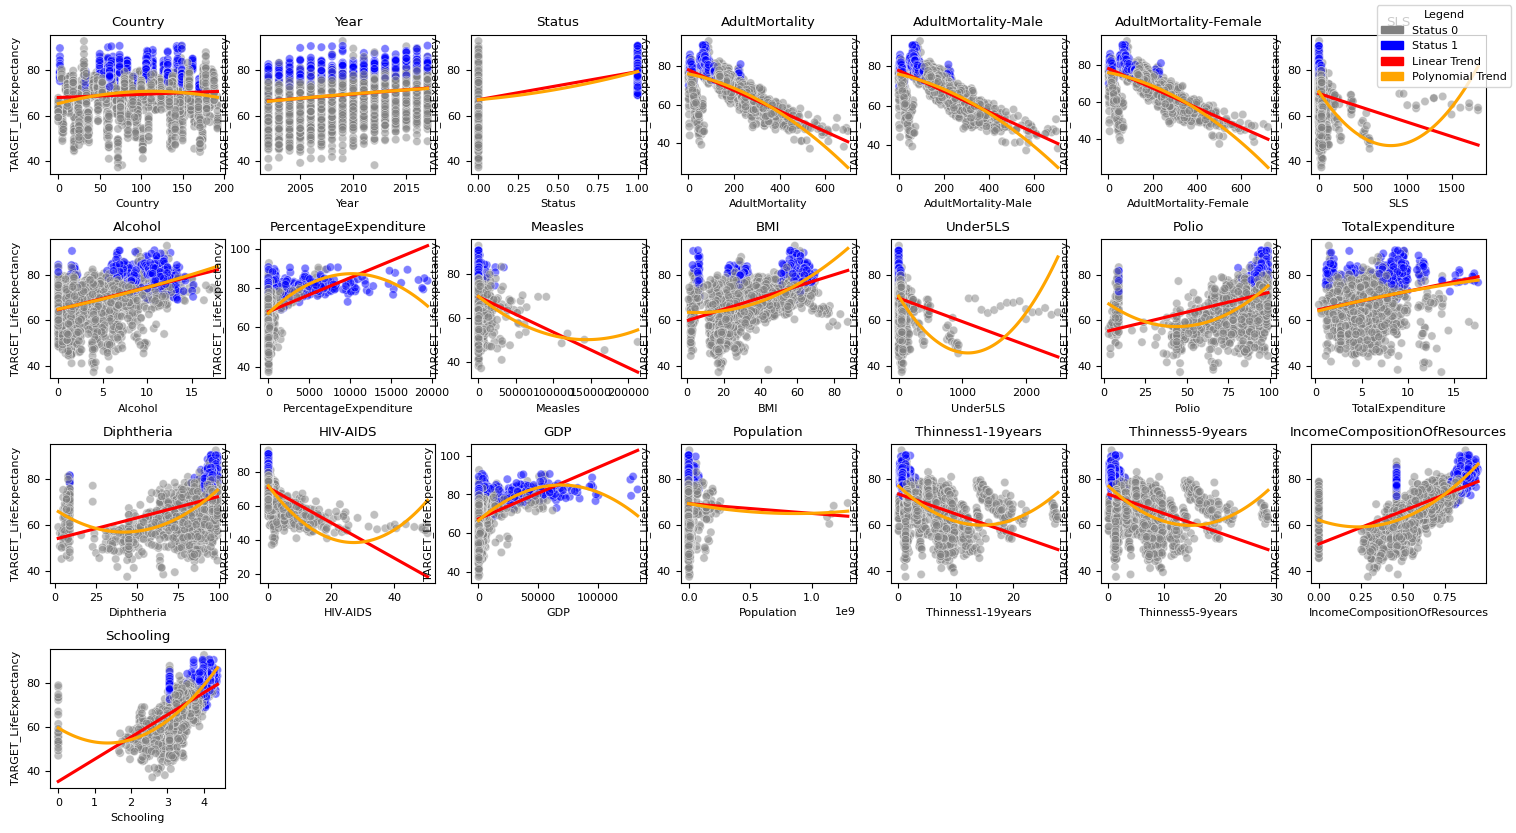

In [6]:
# Build a scatterplot of each independent variable against the target variable to see the relationship

# Format the figure size based on the number of columns
num_columns = len(df_raw_train_w_target.columns) - 1  # Adjusted for excluding the target variable itself
cols_in_grid = 7  # Set your desired number of columns per row
rows_in_grid = 5  # Ceiling division to calculate the rows

plt.figure(figsize=(15,10))
# Loop through each input feature in the DataFrame and plot a scatter plot
for i, col in enumerate(df_raw_train_w_target.drop('TARGET_LifeExpectancy', axis=1).columns):
    plt.subplot(rows_in_grid, cols_in_grid, i+1)
    # Scatter plot colored by 'Status' with transparency and no legend for each subplot
    sns.scatterplot(data=df_raw_train_w_target, x=col, y='TARGET_LifeExpectancy', hue='Status', palette=['grey', 'blue'], alpha=0.5, legend=False)
    # Add a Linear regression line
    sns.regplot(data=df_raw_train_w_target, x=col, y='TARGET_LifeExpectancy', scatter=False, order=1, ci=None, line_kws={'color':'red'})
    # Add Polynomial regression line
    sns.regplot(data=df_raw_train_w_target, x=col, y='TARGET_LifeExpectancy', scatter=False, order=2, ci=None, line_kws={'color':'orange'})
    plt.title(col)

# Create custom patches as handles for the legend
grey_patch = patches.Patch(color='grey', label='Status 0')
blue_patch = patches.Patch(color='blue', label='Status 1')
red_line = patches.Patch(color='red', label='Linear Trend')
orange_line = patches.Patch(color='orange', label='Polynomial Trend')
# Add the legend to the figure with these custom patches
plt.figlegend(handles=[grey_patch, blue_patch, red_line, orange_line], loc='upper right', title='Legend')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

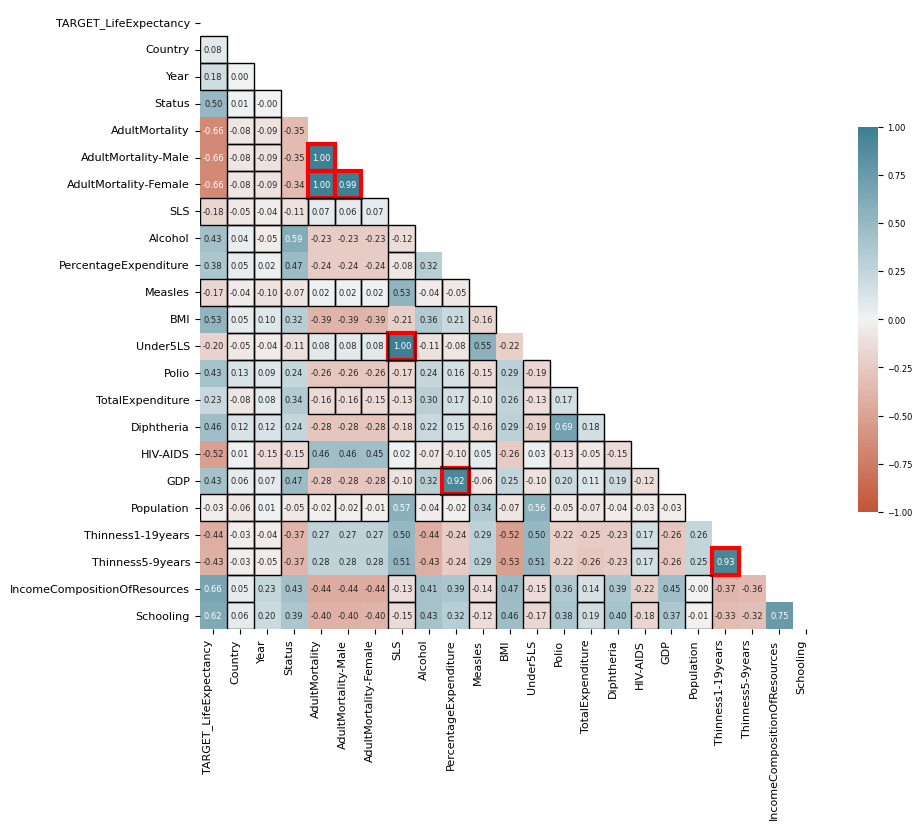

In [7]:
# Build a heatmap of the correlation matrix for the training data
# The purpose of this is to identify any strong correlations between independent variables and the target variable
plt.rcParams.update({'font.size': 6})  # Adjust font size here

# Calculate the correlation matrix
corr = df_raw_train_w_target.corr()
# Generate a mask for the upper triangle. This is to avoid duplicate values in the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Draw the heatmap with the mask
heatmap = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 6},
    cbar=True,
    cbar_kws={"shrink": 0.5}  # Adjusts the color bar size
)
# Adjusting the tick labels font size
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# Loop through the data to add the red boxes on the visible (lower half) part where the correlation is strong (above or equal to 0.8)
for i in range(len(corr.columns)):
    for j in range(i):  # Adjust loop to go over only the lower half
        if abs(corr.iloc[i, j]) >= 0.8:  # Check for absolute correlation above or equal to 0.8
            # Add a rectangle in the visible (lower) half
            ax.add_patch(patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3))
# Loop through the data to add the black boxes where the correlation is neutral (between -0.2 and 0.2)
for i in range(len(corr.columns)):
    for j in range(i):  # Adjust loop to go over only the lower half
        if abs(corr.iloc[i, j]) >= -0.2 and abs(corr.iloc[i, j]) <= 0.2:
            # Add a rectangle in the visible (lower) half
            ax.add_patch(patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1))
plt.show()

BASELINE MODEL - POLYNOMIAL REGRESSION

Purpose:
- Serves as an initial benchmark for performance, guiding the development of more refined models.
- Prioritises simplicity for ease of interpretation.
- Helps determine the necessity of more complex models based on initial performance metrics.

Process:
- Chosen based on EDA insights indicating non-linear relationships between some variables and the target.
- Utilises raw data without preprocessing for outliers, feature selection, or scaling.
- Employs a random split for training and testing, potentially leading to non-independence and data leakage.

Performance:
- Exhibits moderate effectiveness with an R-squared of 0.63, indicating potential but significant room for enhancement.
- Features a negative Adjusted R-squared (-0.12), hinting at possible overfitting due to the model's complexity versus the number of predictors.
- Shows higher error metrics (MAE: 3.54, MSE: 31.86, RMSE: 5.64), underscoring the need for accuracy and consistency improvements.

In [8]:
# Make a copy of the training data for baseline model and join target variable
df_train = df_raw_train.copy()
df_train['TARGET_LifeExpectancy'] = df_raw_train_target_only

# Split data into training and validation sets
# Note: random splitting, without looking at data independence between training and validation sets
with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=0)

# Print the number of rows in each set    
print('There are {} rows in the training set and {} rows in the validation set.'.format(train_data.shape[0], val_data.shape[0]))
print('The training data represents {:.0f}% and the test data represents {:.0f}% of the total data.'.format(train_data.shape[0] / df_train.shape[0] * 100, val_data.shape[0] / df_train.shape[0] * 100))

There are 1656 rows in the training set and 415 rows in the validation set.
The training data represents 80% and the test data represents 20% of the total data.


In [9]:
# Split the training and test data into features and target variable
train_X = train_data.drop(['TARGET_LifeExpectancy'], axis=1)
train_y = train_data[['TARGET_LifeExpectancy']]
test_X = val_data.drop(['TARGET_LifeExpectancy'], axis=1)
test_y = val_data[['TARGET_LifeExpectancy']]

In [10]:
# Transforming the features into polynomial features
degree = 2  # Degree of polynomial features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
train_X_poly = poly_features.fit_transform(train_X)
test_X_poly = poly_features.transform(test_X)

# Fitting the linear regression model on the polynomial features
model_poly = LinearRegression().fit(train_X_poly, train_y)

# Predicting with the polynomial model
y_val_pred_baseline = model_poly.predict(test_X_poly)
y_val_pred_baseline = np.round(y_val_pred_baseline, 2).flatten()
# Ensure data is in the correct format
test_y = np.array(test_y).astype(float).flatten()

Baseline Model Performance: Polynomial Regression
R-squared: 0.63
Adjusted R-squared: -0.12
Mean Absolute Error (MAE): 3.54
Mean Squared Error (MSE): 31.86
Root Mean Squared Error (RMSE): 5.64


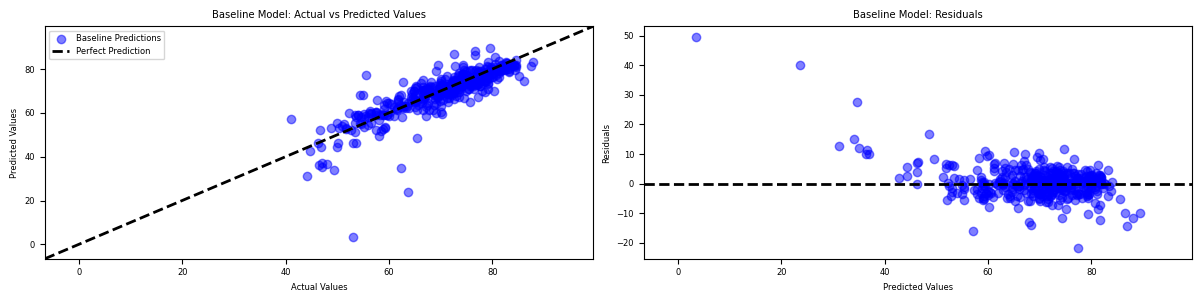

In [11]:
# Model Performance: Performance metrics, Plot of Actual vs Predicted Values and Residuals

# Performance metrics
r2 = r2_score(test_y, y_val_pred_baseline)
adj_r2 = 1 - (1-r2)*(len(test_y)-1)/(len(test_y)-test_X_poly.shape[1]-1)
mae = mean_absolute_error(test_y, y_val_pred_baseline)
mse = mean_squared_error(test_y, y_val_pred_baseline)
rmse = np.sqrt(mse)

# save metrics to a df for future comparison to optimised models
baseline_metrics = pd.DataFrame({'Model': 'Baseline Polynomial Regression', 'R-squared': r2, 'Adjusted R-squared': adj_r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}, index=[0])

# print the performance metrics
print('Baseline Model Performance: Polynomial Regression')
print(f"R-squared: {r2:.2f}")
print(f"Adjusted R-squared: {adj_r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Set the minimum and maximum values for the plot
min_val = min(np.min(test_y), np.min(y_val_pred_baseline)) - 10
max_val = max(np.max(test_y), np.max(y_val_pred_baseline)) + 10

fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # 1 row, 2 columns
# Plot for Actual vs Predicted Values
axs[0].scatter(test_y, y_val_pred_baseline, c='blue', label='Baseline Predictions', alpha=0.5)
axs[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
axs[0].set_xlim(min_val, max_val)
axs[0].set_ylim(min_val, max_val)
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Baseline Model: Actual vs Predicted Values')
axs[0].legend()
# Plot for Residuals
residuals_baseline = test_y - y_val_pred_baseline
axs[1].scatter(y_val_pred_baseline, residuals_baseline, c='blue', alpha=0.5)
axs[1].plot([min_val, max_val], [0, 0], 'k--', lw=2)
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Baseline Model: Residuals')
axs[1].set_xlim(min_val, max_val)
plt.tight_layout()
plt.show()

OPTIMISED MODEL - POLYNOMIAL REGRESSION

Purpose: To enhance the baseline model's prediction accuracy through iterative improvements.

Process:
- Conducts minor data cleaning, including removal of countries with sparse or inconsistent data and outliers.
- Implements one-hot encoding and selects training-validation splits by country to avoid data leakage and ensure model validity on unseen groups.
- Applies feature scaling with PowerTransformer and MinMax Scaler for uniformity.

Performance:
- Observes a moderate rise in R-squared from 0.63 to 0.68, indicating a slight enhancement in variance explanation.
- Achieves a significant leap in Adjusted R-squared from -0.12 to 0.53, highlighting improved fit despite increased complexity.
- Notes a minor increase in MAE from 3.54 to 3.98, with reductions in MSE (31.86 to 28.17) and RMSE (5.64 to 5.31), suggesting better management of larger errors and a more accurate model.

Pre-Processing: Check quality of the Population data, based on observations from the EDA

In [12]:
# Get the summary statistics for the population per country
df_raw_train_w_target.groupby('Country')['Population'].describe()
df_country_population = df_raw_train_w_target.groupby('Country')['Population'].describe().reset_index()

# Filter on countries with a standard deviation of 0 - this means that there are no variations in the population and may be manually adjusted
df_country_population_filtered = df_country_population[(df_country_population['std']==0)]
print('Countries with same pop and std of 0: ',df_country_population[df_country_population['std']==0]['Country'].nunique(),' out of total countries',df_raw_train_w_target['Country'].nunique())
print('Countries with less than 16 observations: ',df_country_population[df_country_population['count']<16]['Country'].nunique(),' out of total countries',df_raw_train_w_target['Country'].nunique())

# Remove countries with less than 16 observations
df_train_processed = df_raw_train_w_target[~df_raw_train_w_target['Country'].isin(df_country_population[df_country_population['count']<16]['Country'])]

Countries with same pop and std of 0:  27  out of total countries 136
Countries with less than 16 observations:  7  out of total countries 136


In [13]:
# Filter on countries with less than 2000 population
low_pop = df_train_processed[(df_train_processed['Population']<2000)]['Country'].unique()

# Remove these countries from the training set because of inconsistent population data
df_train_processed = df_train_processed[~df_train_processed['Country'].isin(low_pop)]
df_test_processed = df_raw_test

Pre-processing: Remove Data where the Target is an Outlier

In [14]:
# Identify target outliers in the training data using the interquarterile range (IQR) method
# Calculate the first and third quartiles
Q1 = df_train_processed['TARGET_LifeExpectancy'].quantile(0.25)
Q3 = df_train_processed['TARGET_LifeExpectancy'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identify the outliers
outliers = df_train_processed[(df_train_processed['TARGET_LifeExpectancy'] < lower_bound) | (df_train_processed['TARGET_LifeExpectancy'] > upper_bound)]

In [15]:
# Print the number of outliers
print(f'There are {outliers.shape[0]} outliers in the training data.')

# Remove the outliers from the training data and the outlier target variable
# print the unique values of the outliers 
print('Values of outlier target variables before removing:',outliers['TARGET_LifeExpectancy'].unique())

# remove the outliers
df_train_processed = df_train_processed[(df_train_processed['TARGET_LifeExpectancy'] >= lower_bound) & (df_train_processed['TARGET_LifeExpectancy'] <= upper_bound)]
print(df_train_processed.shape)

There are 9 outliers in the training data.
Values of outlier target variables before removing: [41.2 38.3 41.9 41.1 41.3 39.3 41.6 37.3]
(1895, 23)


Pre-Processing: One Hot Encoding for Status Variable

In [16]:
# Convert the categorical columns to one-hot encoding for Status
df_train_processed = pd.get_dummies(df_train_processed, columns=['Status'])
df_test_processed = pd.get_dummies(df_test_processed, columns=['Status'])

Split Training/ Validation Sets: Hold Out Version

In [17]:
# Unique list of countries
countries = df_train_processed['Country'].unique()

# Split the countries into training and validation sets
train_countries, val_countries = train_test_split(countries, test_size=0.50, random_state=0)
train_data = df_train_processed[df_train_processed['Country'].isin(train_countries)]
val_data = df_train_processed[df_train_processed['Country'].isin(val_countries)]

# Print the number of rows in each set and the percentage of observations in each set out of the total
print(train_data.shape[0], val_data.shape[0], df_test_processed.shape[0])

# print the percentage of observations in the training, validation and test sets out of the total observations across all sets
print('Training set:', round(train_data.shape[0]/(train_data.shape[0]+val_data.shape[0]+df_test_processed.shape[0]),2)*100,'%')
print('Validation set:', round(val_data.shape[0]/(train_data.shape[0]+val_data.shape[0]+df_test_processed.shape[0]),2)*100,'%')
print('Test set:', round(df_test_processed.shape[0]/(train_data.shape[0]+val_data.shape[0]+df_test_processed.shape[0]),2)*100,'%')

# check there is no overlap of countries in the training, validation and test sets
train_countries = train_data['Country'].unique()
val_countries = val_data['Country'].unique()
test_countries = df_test_processed['Country'].unique()
overlap = [country for country in train_countries if country in val_countries or country in test_countries]
print('Countries which are not independent to their train, validation and test partitions:', overlap)

943 952 867
Training set: 34.0 %
Validation set: 34.0 %
Test set: 31.0 %
Countries which are not independent to their train, validation and test partitions: []


Pre-Processing: Feature Scaling

In [18]:
# Copy the training, validation and test sets, in case we need to refer back to the original data
train_scaled = train_data.copy()
val_scaled = val_data.copy()
test_scaled = df_test_processed.copy()

# Convert columns in training and test set to float
train_scaled = train_scaled.astype(float)
val_scaled = val_scaled.astype(float)
test_scaled = test_scaled.astype(float)

In [27]:
# Separate features and target for the training and validation sets
X_train = train_scaled.drop(columns=['TARGET_LifeExpectancy'])
y_train = train_scaled['TARGET_LifeExpectancy']
X_val = val_scaled.drop(columns=['TARGET_LifeExpectancy'])
y_val = val_scaled['TARGET_LifeExpectancy']

# Test data does not have the target column
X_test = test_scaled

# Initialize PowerTransformer and MinMaxScaler
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
minmax_scaler = MinMaxScaler()

# Fit and transform the training data with PowerTransformer
X_train_power = power_transformer.fit_transform(X_train)
# Apply the transformation to validation and test sets
X_val_power = power_transformer.transform(X_val)
X_test_power = power_transformer.transform(X_test)

# Apply MinMax scaling on the data transformed by PowerTransformer
# Fit and transform the training data
X_train_scaled = minmax_scaler.fit_transform(X_train_power)
# Transform the validation and test sets
X_val_scaled = minmax_scaler.transform(X_val_power)
X_test_scaled = minmax_scaler.transform(X_test_power)

# Convert the scaled arrays back to dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


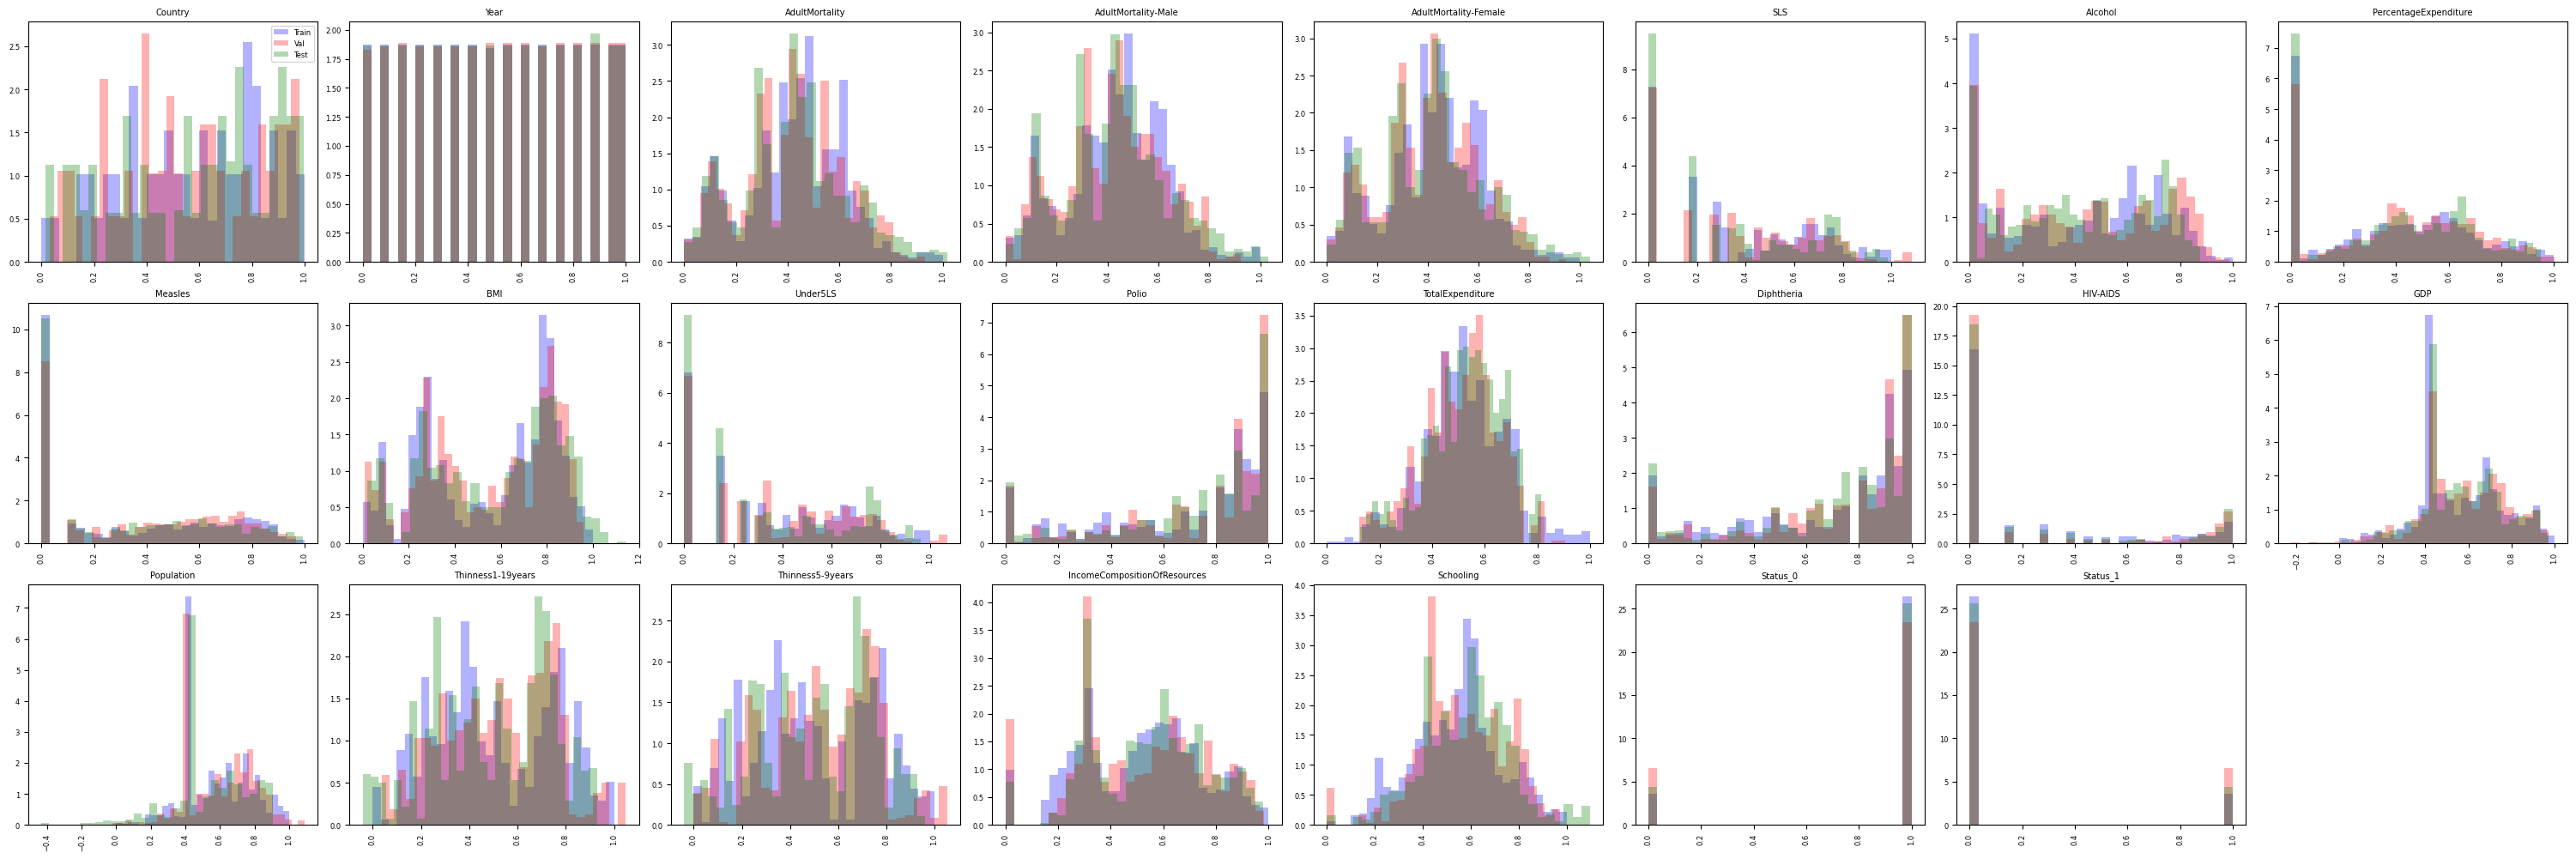

In [28]:
# Post-scaling independent variables histograms
columns_to_plot = X_train_scaled_df.columns  # Use all columns

num_columns = len(columns_to_plot)  # Total number of columns
cols_in_grid = 8  # Desired number of columns per row in the plot grid
rows_in_grid = 3 # Ceiling division to calculate the rows

plt.figure(figsize=(30, 10))  # Adjust the figure size dynamically based on the number of rows
for i, col in enumerate(columns_to_plot):
    plt.subplot(rows_in_grid, cols_in_grid, i+1)
    plt.hist(X_train_scaled_df[col], alpha=0.3, color='blue', density=True, bins=30, label='Train')
    plt.hist(X_val_scaled_df[col], alpha=0.3, color='red', density=True, bins=30, label='Val')
    plt.hist(X_test_scaled_df[col], alpha=0.3, color='green', density=True, bins=30, label='Test')
    plt.title(col)
    plt.xticks(rotation='vertical')
    if i == 0:  # Add legend to only the first subplot for clarity
        plt.legend()

plt.tight_layout()
plt.show()

Generate Predictions

In [29]:
# Step 1: Create polynomial features and split into training and validation sets
degree = 2
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled_df)
X_val_poly = poly_features.transform(X_val_scaled_df)
X_test_poly = poly_features.transform(X_test_scaled_df)

# Step 2: Fit the Linear Regression model, with polynomial features and target from the training set
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Step 3: Make predictions based on the polynomial model features from the validation set
y_val_pred_poly = poly_model.predict(X_val_poly)

In [30]:
# Step 4: Build the Performance metrics
val_mse_poly = mean_squared_error(y_val, y_val_pred_poly)
val_r2_poly = r2_score(y_val, y_val_pred_poly)
val_mae_poly = mean_absolute_error(y_val, y_val_pred_poly)
val_rmse_poly = np.sqrt(val_mse_poly)
n = len(y_val)  # Number of observations
p = X_val_poly.shape[1]  # Number of predictors
val_adj_r2_poly = 1 - (1-val_r2_poly) * (n - 1) / (n - p - 1)

# save metrics to a df for future comparison to optimised models
poly_metrics = pd.DataFrame({'Model': 'Polynomial Regression', 'R-squared': val_r2_poly, 'Adjusted R-squared': val_adj_r2_poly, 'MAE': val_mae_poly, 'MSE': val_mse_poly, 'RMSE': val_rmse_poly}, index=[0])


Test set predictions exported to 'poly_test_predictions.csv'.


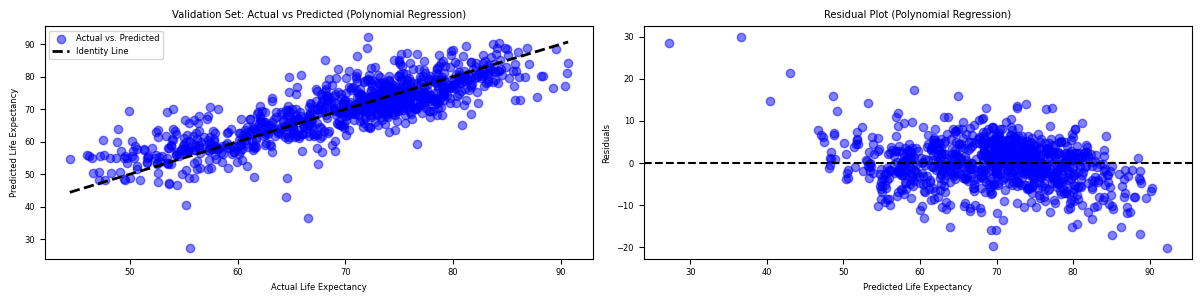

Polynomial Regression Model Performance
R-squared: 0.68 (Baseline: 0.63)
Adjusted R-squared: 0.53 (Baseline: -0.12)
Mean Absolute Error (MAE): 3.98 (Baseline: 3.54)
Mean Squared Error (MSE): 28.17 (Baseline: 31.86)
Root Mean Squared Error (RMSE): 5.31 (Baseline: 5.64)


In [33]:
# Step 5: Predict on the test set and export to CSV
y_test_pred_poly = poly_model.predict(X_test_poly)

# Create a DataFrame with index from X_test_scaled_df and predictions
# use test index ID
poly_predictions_df = pd.DataFrame(y_test_pred_poly, index=X_test_scaled_df.index, columns=['TARGET_LifeExpectancy'])
poly_predictions_df.index.name = 'ID'

# Export predictions to CSV
poly_predictions_df.to_csv('poly_test_predictions.csv')
print("Test set predictions exported to 'poly_test_predictions.csv'.")

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
# Actual vs. Predicted plot
axs[0].scatter(y_val, y_val_pred_poly, alpha=0.5, color='blue', label='Actual vs. Predicted')
axs[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Identity Line')
axs[0].set_xlabel('Actual Life Expectancy')
axs[0].set_ylabel('Predicted Life Expectancy')
axs[0].set_title('Validation Set: Actual vs Predicted (Polynomial Regression)')
axs[0].legend()

# Residuals plot
residuals_poly = y_val - y_val_pred_poly
axs[1].scatter(y_val_pred_poly, residuals_poly, alpha=0.5, color='blue')
axs[1].axhline(y=0, color='k', linestyle='--')
axs[1].set_xlabel('Predicted Life Expectancy')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot (Polynomial Regression)')
plt.tight_layout()
plt.show()

# Print performance metrics (compared to baseline model in the previous cell)
print('Polynomial Regression Model Performance')
print(f"R-squared: {val_r2_poly:.2f} (Baseline: {r2:.2f})")
print(f"Adjusted R-squared: {val_adj_r2_poly:.2f} (Baseline: {adj_r2:.2f})")
print(f"Mean Absolute Error (MAE): {val_mae_poly:.2f} (Baseline: {mae:.2f})")
print(f"Mean Squared Error (MSE): {val_mse_poly:.2f} (Baseline: {mse:.2f})")
print(f"Root Mean Squared Error (RMSE): {val_rmse_poly:.2f} (Baseline: {rmse:.2f})")

Optimisation: Optimise the Model Coefficients (Find Alpha). This value will later be input into the Ridge model.

In [ ]:
# Define a range of alpha values
alphas = np.logspace(-4, 4, 50)

# Lists to store the performance metrics for each alpha value
train_errors = []
val_errors = []

for alpha in alphas:
    # Initialise and fit the Ridge regression model
    model = Ridge(alpha=alpha)
    model.fit(X_train_poly, y_train)
    # Predict on training and validation set
    y_train_pred = model.predict(X_train_poly) # Predict on training set which was used to fit the model
    y_val_pred = model.predict(X_val_poly) # Predict on validation set
    # Calculate MSE for training and validation set
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    # Append the MSEs to the lists
    train_errors.append(train_mse)
    val_errors.append(val_mse)
# Find the index of the minimum validation error
min_val_error_idx = np.argmin(val_errors)
# Find the corresponding optimal alpha value
optimal_alpha = alphas[min_val_error_idx]
# Find the corresponding minimum validation error for plotting
min_val_error = val_errors[min_val_error_idx]

In [ ]:
# Print the optimal alpha value
print(f"Optimal Alpha: {optimal_alpha:.4f}")
plt.style.use('default')  # Use default style with a white background
plt.figure(figsize=(8, 3))
# Plot training and validation errors with a clear and simple design
plt.plot(alphas, train_errors, 'o-', color='dodgerblue', label='Training Error', linewidth=1.5, markersize=4)
plt.plot(alphas, val_errors, 's-', color='darkorange', label='Validation Error', linewidth=1.5, markersize=4)
plt.scatter(optimal_alpha, min_val_error, color='red', s=80, label='Optimal Alpha', zorder=5, edgecolor='black', linewidth=0.5)

# Simplify the plot design for clarity
plt.xscale('log')  # Log scale for alpha values
plt.xlabel('Alpha', fontsize=6)
plt.ylabel('Mean Squared Error', fontsize=6)
plt.title('Training & Validation Error by Alpha (Ridge Regression)', fontsize=8)
plt.legend(fontsize=6, loc='upper right')
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)  # Lighter gridlines

# Annotate the optimal alpha value subtly
plt.annotate(f"{optimal_alpha:.2e}", xy=(optimal_alpha, min_val_error),
             xytext=(10, 25), textcoords='offset points',
             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3'),
             horizontalalignment='center', verticalalignment='top', fontsize=8)
plt.tight_layout()
plt.show()

Regularisation on Polynomial Model

Purpose: Aims to mitigate overfitting by incorporating a penalty (L2) on the loss function, shrinking coefficients towards zero to handle multicollinearity and correlated features.

Key Features:
- Utilises the L2 penalty, summing squared coefficients to diminish the effect of multicollinearity (impact of high intercorrelations between two or more independent variables).
- Employs the alpha parameter to adjust penalty strength, influencing coefficient shrinkage.

Performance:
- Achieved a significant boost in fit, with R-squared soaring to 0.82, demonstrating a higher data variance accuracy over the Polynomial (0.68) and Baseline (0.63) models.
- Adjusted R-squared rose to 0.74, marking a substantial improvement and validating the model's complexity.
- Notably reduced error metrics (MAE, MSE, RMSE) compared to earlier models, indicating more accurate predictions.
- Ridge Regression notably surpasses both the optimised and baseline models in performance.


In [ ]:
# Initialize the Ridge regression model
ridge_model = Ridge(alpha=optimal_alpha)

# Fit the model on the polynomial features of the training data
ridge_model.fit(X_train_poly, y_train)

# Make predictions on the validation set
y_val_pred_ridge = ridge_model.predict(X_val_poly)

In [ ]:
# Calculate performance metrics for the Ridge Regression model
ridge_val_mse = mean_squared_error(y_val, y_val_pred_ridge)
ridge_val_r2 = r2_score(y_val, y_val_pred_ridge)
ridge_val_mae = mean_absolute_error(y_val, y_val_pred_ridge)
ridge_val_rmse = np.sqrt(ridge_val_mse)
ridge_n = len(y_val)  # Number of observations
ridge_p = X_val_poly.shape[1]  # Number of predictors
ridge_val_adj_r2 = 1 - (1-ridge_val_r2) * (ridge_n - 1) / (ridge_n - ridge_p - 1)

# Save the Ridge Regression metrics to a DataFrame
ridge_metrics = pd.DataFrame({
    'Model': 'Ridge Regression',
    'R-squared': [ridge_val_r2],
    'Adjusted R-squared': [ridge_val_adj_r2],
    'MAE': [ridge_val_mae],
    'MSE': [ridge_val_mse],
    'RMSE': [ridge_val_rmse]
})

In [ ]:
# Make predictions on the test set
y_test_pred_ridge = ridge_model.predict(X_test_poly)

# To output test predictions linked to the index and export as a CSV file:
ridge_predictions_df = pd.DataFrame(y_test_pred_ridge, index=X_test_scaled_df.index, columns=['TARGET_LifeExpectancy'])
ridge_predictions_df.index.name = 'ID'

ridge_predictions_df.to_csv('ridge_test_predictions.csv')
print("Test set predictions exported to 'ridge_test_predictions.csv'.")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # 1 row, 2 columns layout
# Actual vs. Predicted Values Plot for both models
axs[0].scatter(y_val, y_val_pred_poly, alpha=0.2, color='red', label='Polynomial Predicted')
axs[0].scatter(y_val, y_val_pred_ridge, alpha=0.5, color='green', label='Ridge Predicted')
axs[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Identity Line')
axs[0].set_xlabel('Actual Life Expectancy')
axs[0].set_ylabel('Predicted Life Expectancy')
axs[0].set_title('Validation Set: Actual vs Predicted Life Expectancy')
axs[0].legend()

# Residuals Plot for both models
residuals_poly = y_val - y_val_pred_poly
residuals_ridge = y_val - y_val_pred_ridge
axs[1].scatter(y_val_pred_poly, residuals_poly, alpha=0.2, color='red', label='Polynomial Residuals')
axs[1].scatter(y_val_pred_ridge, residuals_ridge, alpha=0.5, color='green', label='Ridge Residuals')
axs[1].axhline(y=0, color='k', linestyle='--')
axs[1].set_xlabel('Predicted Life Expectancy')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Validation Set: Residual Plot for Models')
plt.tight_layout()
plt.show()

# Print performance metrics (compared to polynomial and baseline model in the previous cell)
print('Ridge Regression Model Performance')
print(f"R-squared: {ridge_val_r2:.2f} (Polynomial: {val_r2_poly:.2f}, Baseline: {r2:.2f})")
print(f"Adjusted R-squared: {ridge_val_adj_r2:.2f} (Polynomial: {val_adj_r2_poly:.2f}, Baseline: {adj_r2:.2f})")
print(f"Mean Absolute Error (MAE): {ridge_val_mae:.2f} (Polynomial: {val_mae_poly:.2f}, Baseline: {mae:.2f})")
print(f"Mean Squared Error (MSE): {ridge_val_mse:.2f} (Polynomial: {val_mse_poly:.2f}, Baseline: {mse:.2f})")
print(f"Root Mean Squared Error (RMSE): {ridge_val_rmse:.2f} (Polynomial: {val_rmse_poly:.2f}, Baseline: {rmse:.2f})")


In [ ]:
# print total predictions for both compared to original index count of test set
print('Total predictions for Polynomial Regression:',poly_predictions_df.shape[0])
print('Total predictions for Ridge Regression:',ridge_predictions_df.shape[0])
print('Total predictions for Test Set:',df_raw_test.shape[0])

plt.figure(figsize=(5, 2))  # Smaller figure size
plt.plot(poly_predictions_df, label='Polynomial Regression', color='red', linewidth=1)
plt.plot(ridge_predictions_df, label='Ridge Regression', color='green', linewidth=1)

# Adjusting font sizes and tick parameters
plt.xlabel('Index', fontsize=8)
plt.ylabel('Value', fontsize=8) 
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('Prediction Comparison', fontsize=10)  # Adding a title with a smaller font size
plt.legend(fontsize=6, loc='best')  # Reduces legend font size and optimizes location
plt.tight_layout() 
plt.show()